# Towhee image search

## Preparation

- data Preparation

In [1]:
# ! unzip image_dataset.zip

# load json data to diskcache
import json
from diskcache import Cache

cache = Cache('./tmp')

def read_json_to_cache(file, swap=False):
    with open(file) as f:
        data = f.read()
    data = json.loads(data)
    if swap:
        data = {value:key for key, value in data.items()}
    for k in data:
        cache[k] = data[k]

read_json_to_cache('id_img.json')
read_json_to_cache('id_img.json', True)

- Create Milvus collection and build index

In [2]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# create reverse_image_search collection and build index
def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":2048}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection


collection = create_milvus_collection('reverse_image_search', 2048)

## Reverse image search with Towhee

In [4]:
import time
import towhee

milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/reverse_image_search')

time1 = time.time()
with milvus_collection:
    dc = (
        towhee.glob['path']('./extracted_train/*/*.JPEG')
          .image_decode['path', 'img']()
          .runas_op['path', 'id'](func = lambda path: int(cache[path]))
          .image_embedding.timm['img', 'vec'](model_name='resnet50')
          .batch(100)
          .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
          .run()
    )
print(time.time()-time1)

32.162221908569336



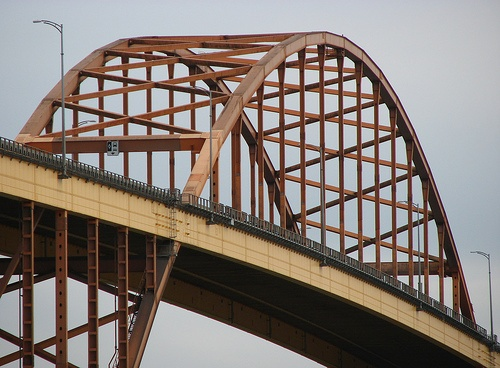
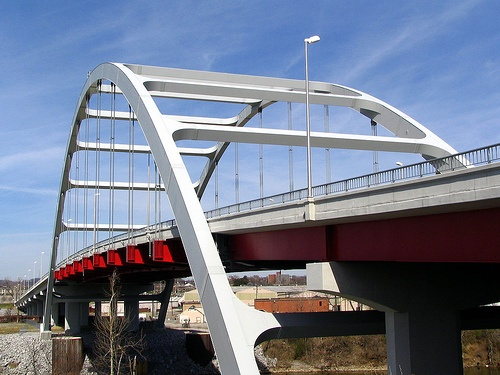
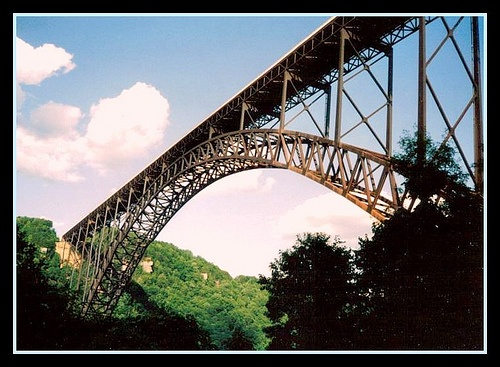
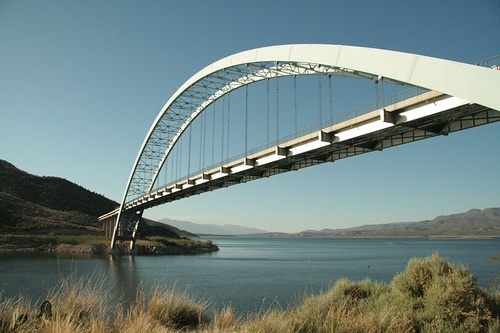
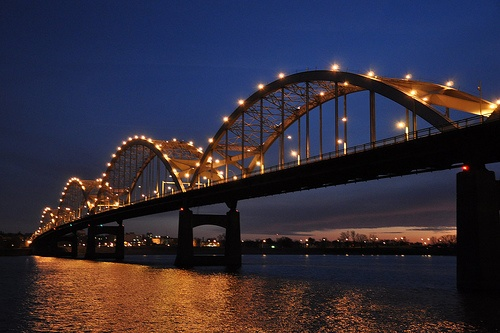
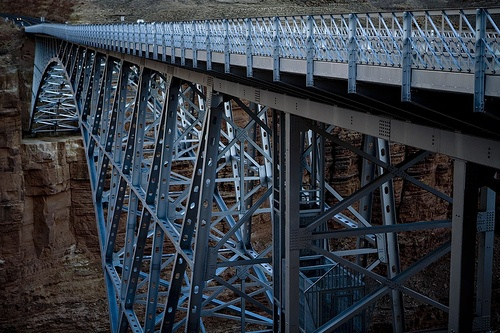
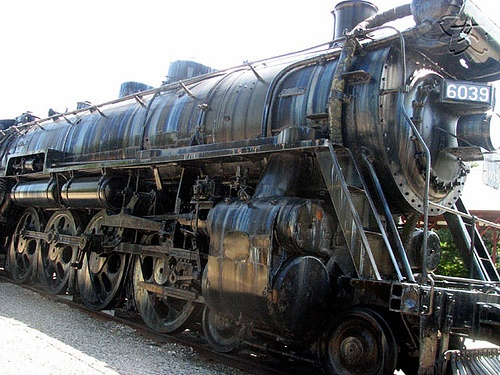
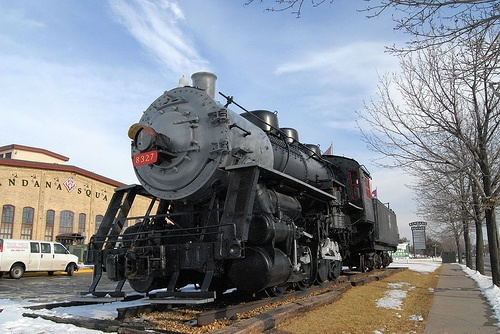
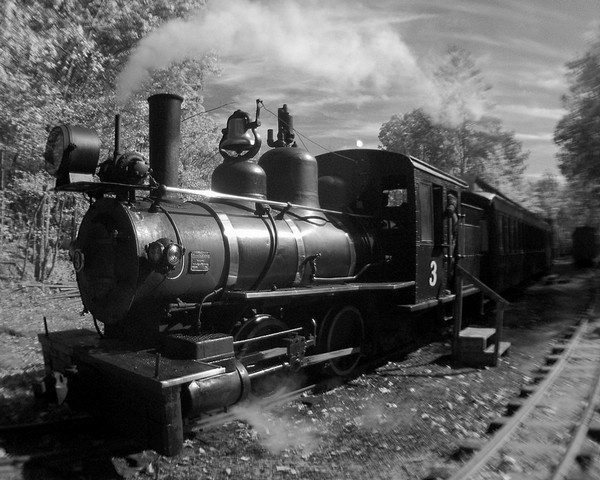
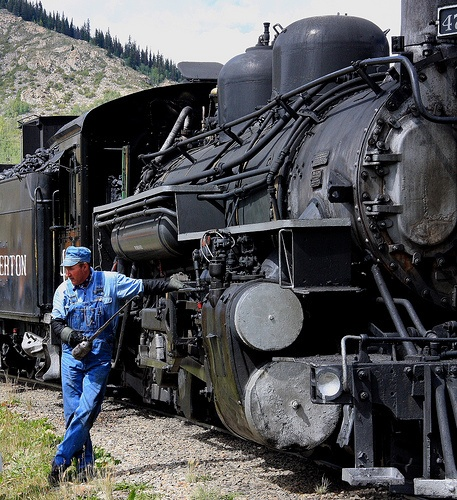
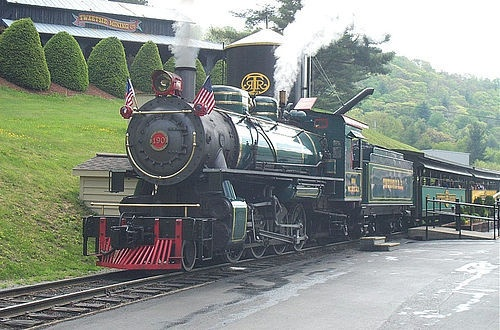
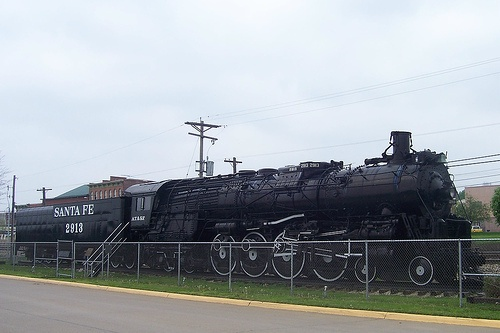
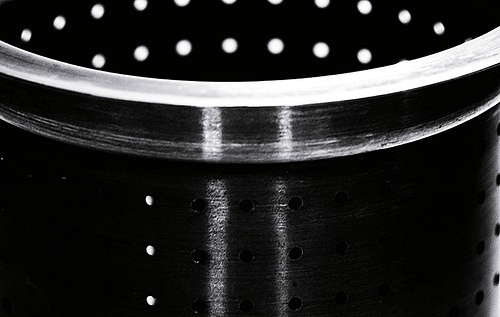
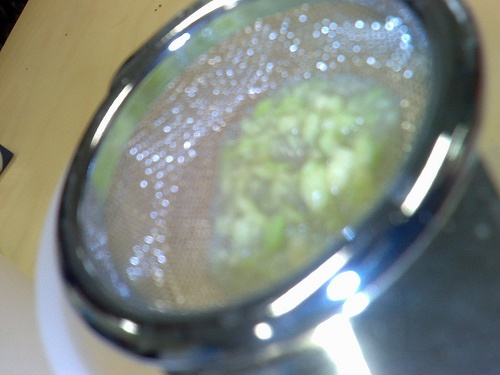
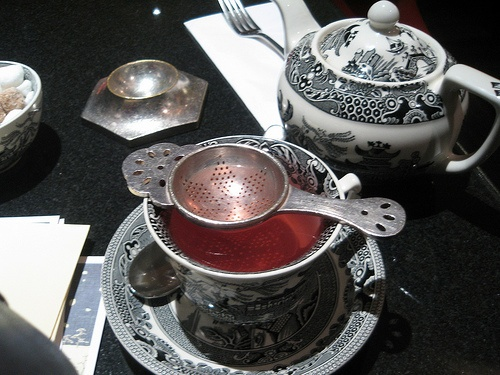
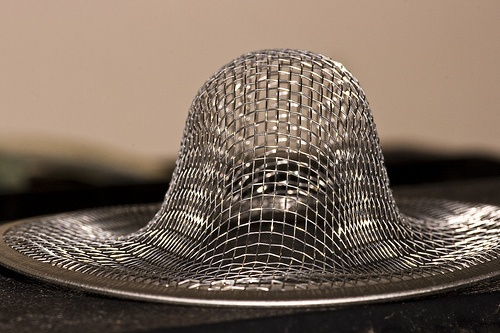
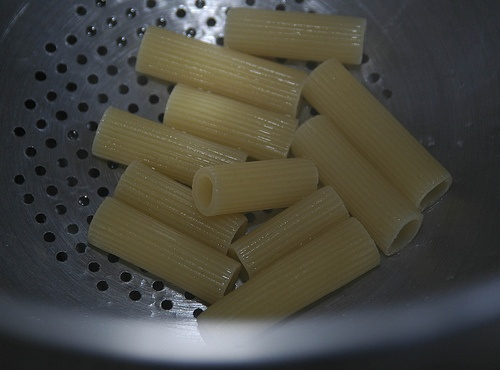
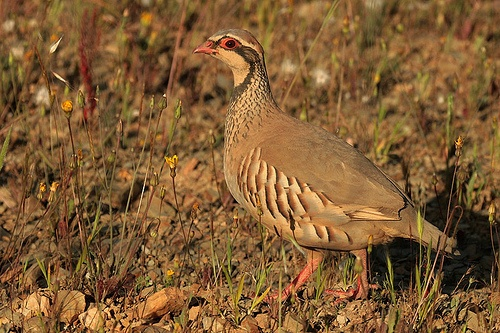

In [5]:
import cv2
from towhee._types.image import Image

with milvus_collection:
    (
  towhee.glob['path']('./extracted_test/n043*/*.JPEG')
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .ann_search['vec', 'result'](ann_index=milvus_collection, limit=5)
        .runas_op['result', 'result_img'](func=lambda res: [Image(cv2.imread(cache[x.id]), 'BGR') for x in res])
        .select['img', 'result_img']()
        .show()
    )

## Play with gradio

In [6]:
from towhee.types.image_utils import from_pil
import gradio

milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/reverse_image_search')

with towhee.api() as api:
    search_in_milvus = (
        api.runas_op(func=lambda img: from_pil(img))
        .image_embedding.timm(model_name='resnet50')
        .ann_search(ann_index=milvus_collection, limit=5)
        .runas_op(func=lambda res: [cache[x.id] for x in res])
        .as_function()
        )

interface = gradio.Interface(search_in_milvus, 
                             gradio.inputs.Image(type="pil", source='upload'),
                             [gradio.outputs.Image(type="file", label=None) for _ in range(5)]
                            )

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://43631.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f1fbc412970>,
 'http://127.0.0.1:7860/',
 'https://43631.gradio.app')

## Advanced Test

In [7]:
# parallel execute
# collection_parallel = create_milvus_collection('reverse_image_search_bak', 2048)
# milvus_collection_parallel = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/reverse_image_search_bak')

In [8]:
# time1 = time.time()
# with milvus_collection_parallel:
#     dc = (
#         towhee.glob['path']('./extracted_train/*/*.JPEG')
#           .set_parallel(3)
#           .image_decode['path', 'img']()
#           .runas_op['path', 'id'](func = lambda path: int(cache[path]))
#           .image_embedding.timm['img', 'vec'](model_name='resnet50')
#           .batch(100)
#           .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
#           .run()
#     )
# print(time.time()-time1)


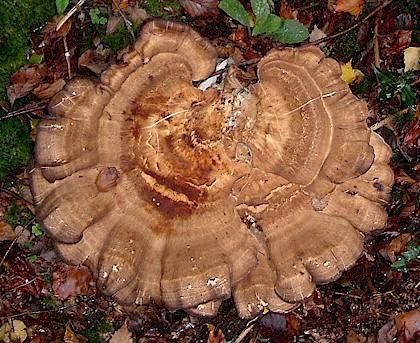
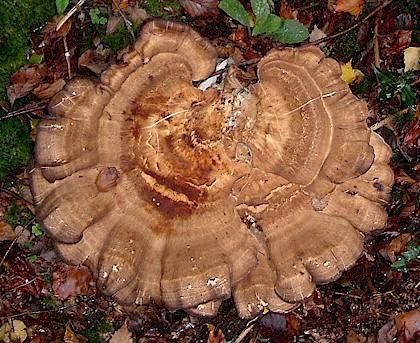
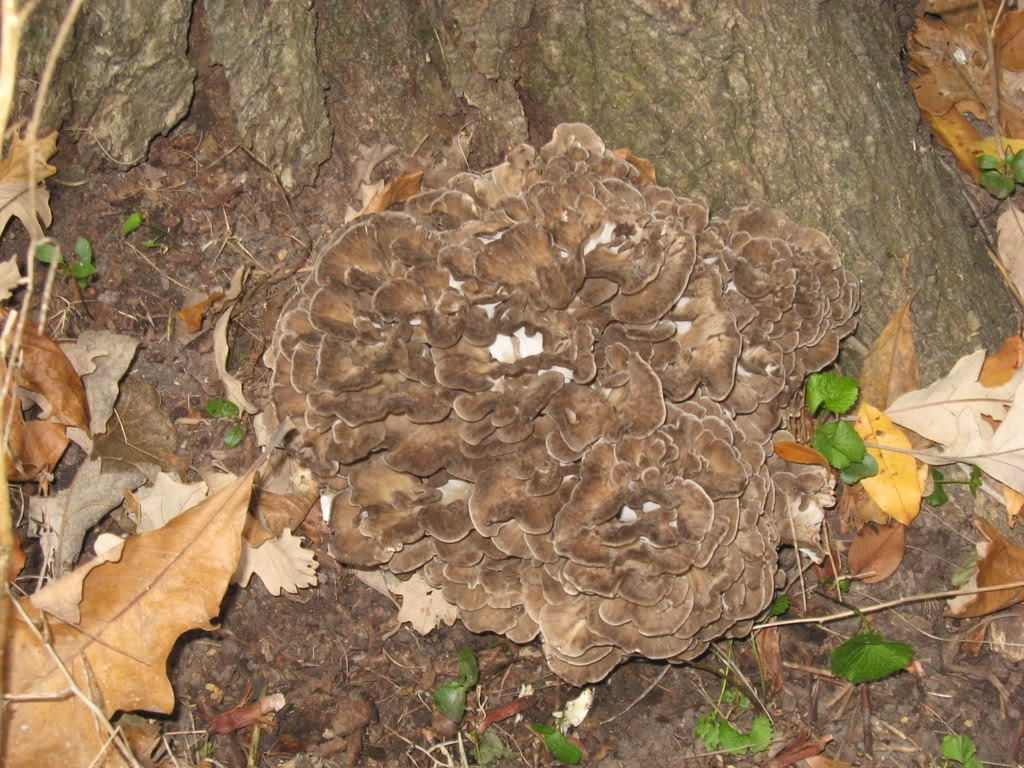
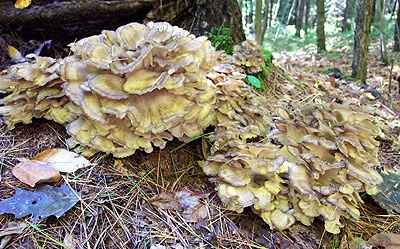
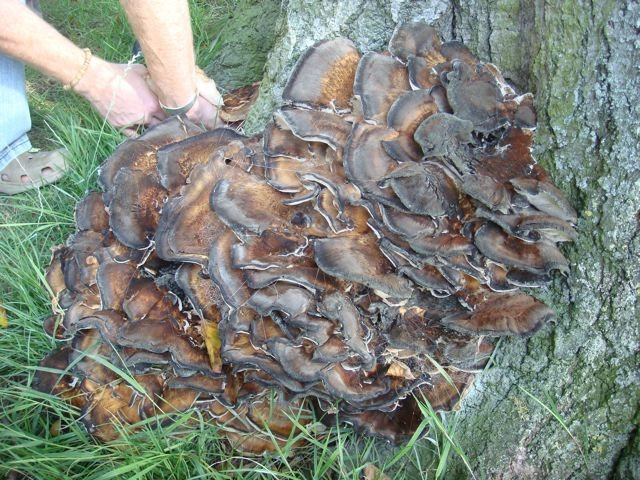
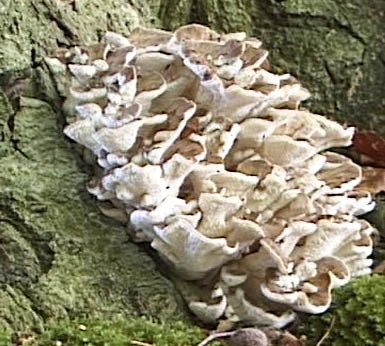
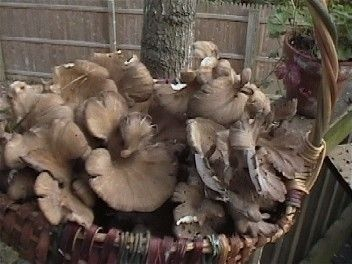
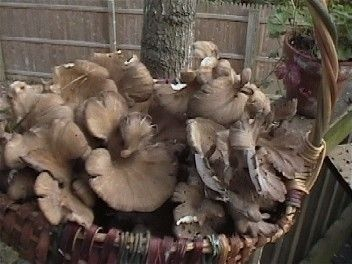
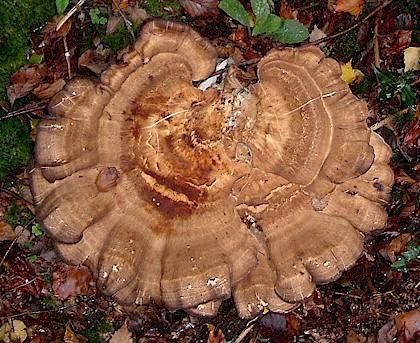
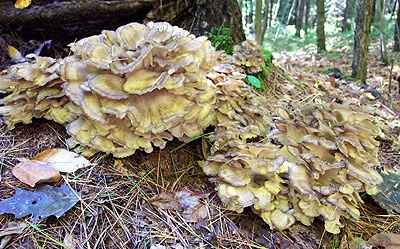
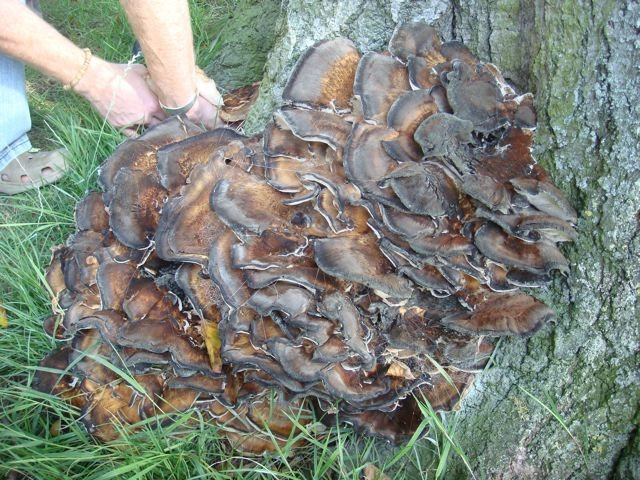
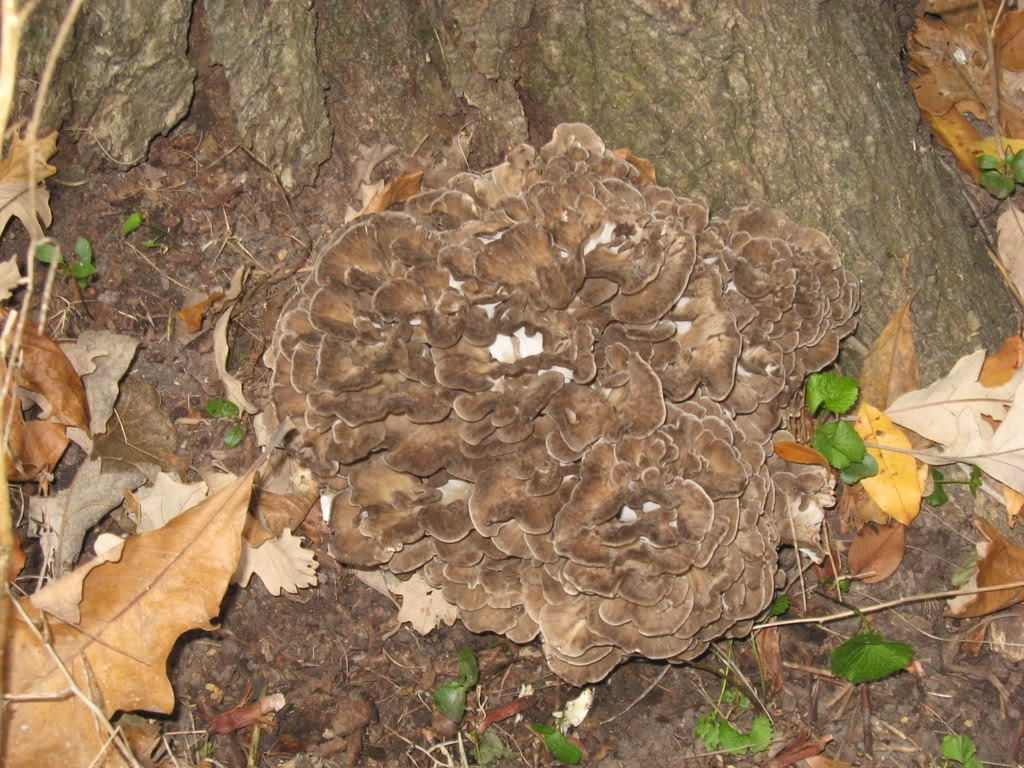
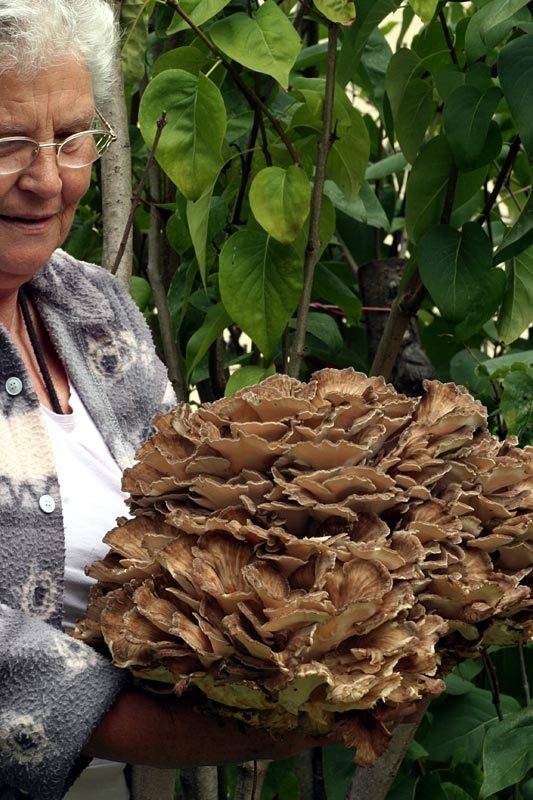
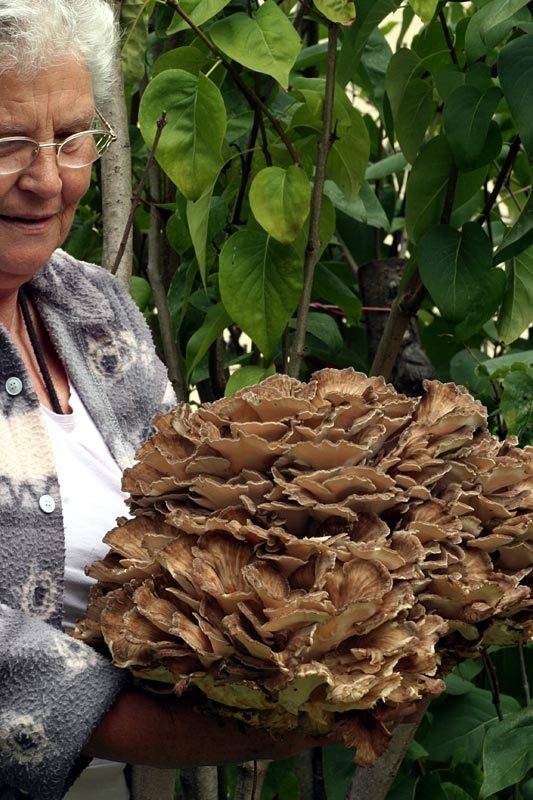
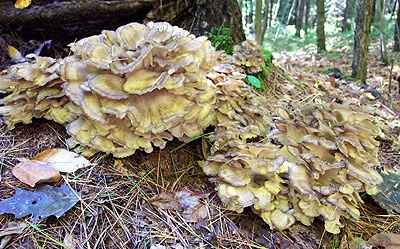
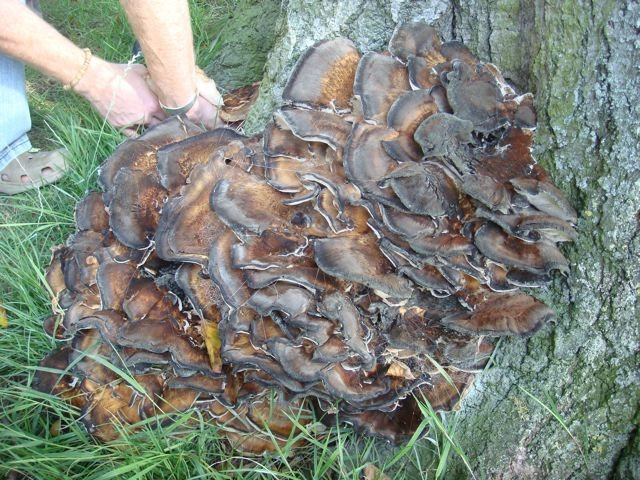
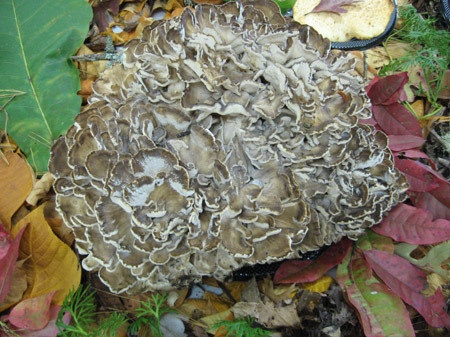
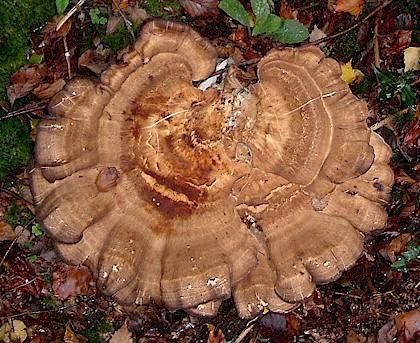

In [24]:
# expetion safe and drop empty
import time
import towhee

milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/reverse_image_search')
with milvus_collection:
    (
  towhee.glob['path']('./exception/*.JPEG')
        .exception_safe()
        .image_decode['path', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet50')
        .ann_search['vec', 'result'](ann_index=milvus_collection, limit=5)
        .runas_op['result', 'result_img'](func=lambda res: [Image(cv2.imread(cache[x.id]), 'BGR') for x in res])
        .drop_empty()
        .select['img', 'result_img']()
        .show()
    )

In [14]:
# metric report
# read_json_to_cache('label_ids.json')

import towhee
model_dim = {
    'resnet50': 2048,
    'resnet101': 2048
}

for model in model_dim:
    collection = create_milvus_collection(model, model_dim[model])
    milvus_collection = towhee.connectors.milvus(uri=f'tcp://127.0.0.1:19530/{model}')
    
    with milvus_collection:
        ( towhee.glob['path']('./extracted_train/*/*.JPEG')
                .image_decode['path', 'img']()
                .runas_op['path', 'id'](func = lambda path: int(cache[path]))
                .image_embedding.timm['img', 'vec'](model_name=model)
                .batch(100)
                .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
                .run()
        )
        
        ( towhee.glob['path']('./extracted_test/*/*.JPEG')
                .image_decode['path', 'img']()
                .image_embedding.timm['img', 'vec'](model_name=model)
                .runas_op['path', 'ground_truth'](func=lambda path: cache[path.split('/')[-2]])
                .ann_search['vec', 'result'](ann_index=milvus_collection)
                .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
                .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
                .evaluate['ground_truth', 'result'](model)
                .report()
        )

mean_hit_ratio  mean_average_precision
resnet50           0.687                 0.88655

mean_hit_ratio  mean_average_precision
resnet101           0.793                0.972958

In [8]:
# Use Huggingface ViT Model with GPU
from transformers import ViTFeatureExtractor, ViTModel
import torch


def vit_embedding_model(img):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    img = img.cv2_to_rgb()
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    model.eval()
    model.to(device)

    inputs = feature_extractor(img, return_tensors="pt")
    outputs = model(inputs['pixel_values'].to(device))

    return outputs.pooler_output.detach().cpu().numpy().flatten()

collection = create_milvus_collection('huggingface_vit', 768)
milvus_collection = towhee.connectors.milvus(uri=f'tcp://127.0.0.1:19530/huggingface_vit')

    
with milvus_collection:
    ( towhee.glob['path']('./extracted_train/*/*.JPEG')
            .image_decode['path', 'img']()
            .runas_op['path', 'id'](func = lambda path: int(cache[path]))
            .runas_op['img', 'vec'](func=vit_embedding_model)
            .batch(100)
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
            .run()
    )

    ( towhee.glob['path']('./extracted_test/*/*.JPEG')
            .image_decode['path', 'img']()
            .runas_op['img', 'vec'](func=vit_embedding_model)
            .runas_op['path', 'ground_truth'](func=lambda path: cache[path.split('/')[-2]])
            .ann_search['vec', 'result'](ann_index=milvus_collection)
            .runas_op['result', 'result'](func=lambda res: [cache[x.id] for x in res])
            .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
            .evaluate['ground_truth', 'result'](model)
            .report()
    )

mean_hit_ratio  mean_average_precision
huggingface_vit           0.459                0.940083

In [16]:
# Use yolo v5 to detect objects
import towhee
import warnings
warnings.filterwarnings("ignore")
collection = create_milvus_collection('yolov5', 2048)
milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/yolov5')

def yolo_embedding_pipeline(img_path):
    objects = (
        towhee.glob['path'](img_path)
            .image_decode['path', 'img']()
            .object_detection.yolov5['img', ('box', 'class', 'score')]()
            .image_crop[('img', 'box'), 'object'](clamp = True)
            .select['object', 'img']()
            .to_list()
    )
    entity = objects[0]
    if len(entity.object) == 0:
        return [towhee.ops.image_embedding.timm(model_name='resnet101')(entity.img)]
    vec = []
    for obj in entity.object:
        vec.append(towhee.ops.image_embedding.timm(model_name='resnet101')(obj))
    return vec


with milvus_collection:
    ( towhee.glob['path']('./extracted_train/*/*.JPEG')
            .runas_op['path', 'vec'](func=yolo_embedding_pipeline)
            .runas_op[('vec','path'), 'id'](func=lambda vec, path: [cache[path] for _ in vec])
            .ann_insert[('id','vec'), 'res'](ann_index=milvus_collection)
            .run()
    )

    ( towhee.glob['path']('./extracted_test/*/*.JPEG')
            .runas_op['path', 'vec'](func=yolo_embedding_pipeline)
            .runas_op['path', 'ground_truth'](func=lambda path: cache[path.split('/')[-2]])
            .ann_search['vec', 'result'](ann_index=milvus_collection, limit=20)
            .runas_op['result', 'result'](func=lambda res: [x.id for x in res])
            .with_metrics(['mean_hit_ratio', 'mean_average_precision'])
            .evaluate['ground_truth', 'result']('yolov5')
            .report()
    )

mean_hit_ratio  mean_average_precision
yolov5           0.661                0.727884

## Run with FastAPI

In [17]:
from fastapi import FastAPI
app = FastAPI()
milvus_collection = towhee.connectors.milvus(uri='tcp://127.0.0.1:19530/resnet101')

@towhee.register(name='get_path_id')
def get_path_id(path):
    timestamp = int(time.time()*10000)
    cache[path] = timestamp
    cache[timestamp] = path
    return int(timestamp)

with towhee.api['file']() as api:
    app_insert = (
        api.image_load['file', 'img']()
        .save_image['img', 'path'](dir='tmp/images')
        .get_path_id['path', 'id']()
        .image_embedding.timm['img', 'vec'](model_name='resnet101')
        .ann_insert[('id', 'vec'), 'res'](ann_index=milvus_collection)
        .select['id', 'path']()
        .serve('/insert', app)
    )

In [18]:
with towhee.api['file']() as api:
    app_search = (
        api.image_load['file', 'img']()
        .image_embedding.timm['img', 'vec'](model_name='resnet101')
        .ann_search['vec', 'result'](ann_index=milvus_collection)
        .runas_op['result', 'res_file'](func=lambda res: [cache[x.id] for x in res])
        .select['res_file']()
        .serve('/search', app)
    )

In [19]:
with towhee.api() as api:
    app_count = (
        api.map(lambda _: milvus_collection.count())
        .serve('/count', app)
        )

In [20]:
import uvicorn
import nest_asyncio

nest_asyncio.apply()
uvicorn.run(app=app, host='0.0.0.0', port=8000)

INFO:     Started server process [20228]
2022-05-01 17:16:27,826 - 139781464597056 - server.py-server:64 - INFO: Started server process [20228]
Started server process [20228]
INFO:     Waiting for application startup.
2022-05-01 17:16:27,828 - 139781464597056 - on.py-on:26 - INFO: Waiting for application startup.
Waiting for application startup.
INFO:     Application startup complete.
2022-05-01 17:16:27,829 - 139781464597056 - on.py-on:38 - INFO: Application startup complete.
Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
2022-05-01 17:16:27,831 - 139781464597056 - server.py-server:199 - INFO: Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:47158 - "POST /count HTTP/1.1" 200 OK
INFO:     127.0.0.1:48102 - "POST /search HTTP/1.1" 200 OK
INFO:     127.0.0.1:48638 - "POST /insert HTTP/1.1" 200 OK
INFO:     127.0.0.1:48926 - "POST /count HTTP/1.1" 200 OK


INFO:     Shutting down
2022-05-01 17:34:19,735 - 139781464597056 - server.py-server:239 - INFO: Shutting down
Shutting down
INFO:     Waiting for application shutdown.
2022-05-01 17:34:19,837 - 139781464597056 - on.py-on:43 - INFO: Waiting for application shutdown.
Waiting for application shutdown.
INFO:     Application shutdown complete.
2022-05-01 17:34:19,838 - 139781464597056 - on.py-on:46 - INFO: Application shutdown complete.
Application shutdown complete.
INFO:     Finished server process [20228]
2022-05-01 17:34:19,839 - 139781464597056 - server.py-server:74 - INFO: Finished server process [20228]
Finished server process [20228]


Then try to run these api with command:
```shell
# upload an image and search
$ curl -X POST "http://0.0.0.0:8000/search"  --data-binary @extracted_test/n01443537/n01443537_3883.JPEG -H 'Content-Type: image/jpeg'
# upload an image and insert
$ curl -X POST "http://0.0.0.0:8000/insert"  --data-binary @extracted_test/n01443537/n01443537_3883.JPEG -H 'Content-Type: image/jpeg'
# count the collection
$ curl -X POST "http://0.0.0.0:8000/count"
```